**João Paulo P. de Almeida** (*jp_bio*)

**Bioinformática UFMG** 

**Projeto Final**  - Esse notebook contém a organização e execução do meu Projeto Final entregue como parte das atividades avaliativas da disciplina "Aprendizado de máquina 2022-1" em 21 de julho de 2022.


**Link para o Video:**
https://youtu.be/PmTp7Q1mDbI

**Enunciado do problema cientifico**
EVEs (Endogenous viral elements) são sequências virais que se integram ao genoma de seus hospedeiros. Diferenciar essas sequências de sequências de virus reais é uma tarefa árdua no contexto de dados de larga escala da área de metagênomica, já que, á nivel de sequência, EVEs possuem todas caracteristicas de sequências virais e são erronemante classificadas como vírus por alinhamento de seuências.

**Objetivo e justificativa resumida**
Separar sequências "virais reais" de "eves" (endogenal viral elements). Gerar classificadores que façam isso automaticamente em futuros trabalhos, pois essa separação "manual" é custosa em termos de recursos humanos e computacionais.
Além disso, trabalhos atuais estão enchendo os bancos de dados com "eves" e as caracterizando como virais, pois sequer possuem recursos para fazer essa diferenciação. Isso leva a interpretações errôneas de fenômenos biológicos e prejudica futuros trabalhos de mineiração de dados e aprendizado de máquina focados em virus utilizando dados públicos.
Nesse trabalho usei dados de RNA-seq de mosquitos, organismos de interesse do laboratório em que faço meu doutorado e um dos vetores virais mais perigosos do planeta. 


**Hipótese**
Atributos que quantifiquem "rastros" da interação de hospedeiros com vírus utilizados para treinar modelos classificadores por aprendizado de máquina serão capazes de descriminar virus reais de EVEs.  

**Descrição resumida para entendimento dos dados**

Cada entrada representa uma sequência classificada inicialmente como "viral" por métodos baseados em similiradade de sequência comparando as exaustivamente contra extensas bases de dados públicas (Genbank - NCBI https://www.ncbi.nlm.nih.gov/genbank/). O id único de cada sequência é gerado pela sua biblioteca de origem (e.g "RNPM71") mais o código gerado pelo software montador (e.g "Contig0_1"), sendo um exemplo de id único completo "RNPM71_Contig0_1".

Lista de Atributos:

 ***run***:  código que designa batch e local da Europa ou do Brasil onde a biblioteca foi gerada; 

 ***lib***: Código que representa a biblioteca de RNA-seq (amostra);

 ***class***: classificação de interesse para esse trabalho, "viral" são sequências de virus reais e "eve" sao sequências de virus que fazem parte do genoma do mosquito e não são mais circulantes (não mais virus). Essas classes foram curadas em meio a dezenas de milhares de outras sequências com conhecimento dos especialistas no nosso laboratório e ferramentas de bioinformática apropriadas;  

 ***name***: código gerado pelo software montador de sequências;

 ***{X15..X35}***: quantida de RNA do tamanho especificado gerado pela fita senso do genoma do vírus durante a interação do vírus com o sistema imune do mosquito. Exemplo "X21": quantidade normalizada de RNAs de 21 nucleotídeos gerados pela interação do vírus que deu origem a essa sequência com o mosquito. Essa quuantificação é obtida com um experimento que gera dados em larga escala (cerca de 2 Gb de dados por amostra) chamado de RNA-seq, onde todos RNAs de uma amostra são sequênciados de uma vez.

 ***{X.15..X.35}***: Mesma explicação dos atributos anteriores, porém gerados pela fita antisenso do vírua do qual a sequência se originou;

 ***{'dens15to18', 'dens20to22', 'dens25to29', 'ratiosi_pi', 'ratio_si',
       'dens18to35'}***: Essas features sao somas ou razoes das features anteriores, levando em conta meu conhecimento bioquimico sobre o fato de que alguns desses tamanhos de RNAs fazer sentido analisar combinando os como features únicas;
 
 ***length***: tamanho da sequência (considerado nas normalizações que geraram os atributos); 

 ***seq_fw***: sequência da fita sense;
  
  ***seq_bw***: sequência da fita antisenso.
     

#**1- Importação das bibliotecas, carregamento, processamento e inspeção dos dados**







Importando o arquivo "Virus_and_EVEs.tab":


In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving Virus_and_EVEs.tab to Virus_and_EVEs.tab


(*Nota para o momento da correção: Trabalho realizado no google colab, por isso o modo de importação da célula acima).  

Importações padrões de bibliotecas para o desenvolvimento do trabalho:

In [ ]:
#Bibliotecas para tratamento dos dados e visualizações gerais
import io
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bibliotecas de uso geral para os experimentos
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score, 
    recall_score, 
    precision_score,
    confusion_matrix, 
    roc_auc_score,
    roc_curve
    )
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

#Bibliotecas para avaliação e seleção dos modelos
from sklearn.model_selection import GridSearchCV

Carregando o dataframe e inspecionando o inspecionando os dados de forma exploratória visualmente:

In [ ]:
#Carregando o dataframe
virus_eves = pd.read_table(io.BytesIO(uploaded['Virus_and_EVEs.tab']), index_col='V1')


In [ ]:
#Dimensoes do dataframe
virus_eves.shape

(2315, 55)

In [ ]:
#Resumo dos dados do dataframe
virus_eves.info()

NameError: ignored

In [ ]:
#Conferindo se há NAs
virus_eves.isna().sum().sort_values(ascending=False)[0:54]#por colunas
virus_eves.isnull().sum().sum() # no data frame inteiro

0

In [ ]:
#Visualizando as primeiras linhas
virus_eves.head()

,run,lib,class,name,X15,X16,X17,X18,X19,X20,...,X.35,dens15to18,dens20to22,dens25to29,ratiosi_pi,ratio_si,dens18to35,length,seq_fw,seq_bw
V1,,,,,,,,,,,,,,,,,,,,,
RKPM26_Contig120_119,caratinga,RKPM26,viral,Contig120_119,0.234105,0.124664,-0.027890,0.176621,0.021856,0.531474,...,-0.317521,1.846663,4.432182,0.073100,4.359081,0.700917,4.722421,481,CGGTGGCAACCCCCGCAAAACCCCGGTTCGTAGCTAGGATGCTTCC...,CCCGTGGTTCTGGGACACAACAGGCGCCGGTGACGACGAAACTTCT...
RKPM26_Contig1819_1818,caratinga,RKPM26,viral,Contig1819_1818,-0.072243,-0.062254,0.019318,0.064599,-0.004654,0.225080,...,-0.308636,2.211863,5.080056,0.903501,4.176555,0.376193,5.382808,1051,GGTCCGGCCGCCGCTGAGGCGGCGGTGTACTTTATCGCCTTGGTGA...,AAGCTTGAGAAATCTATAAAGTATTAGATTATCAAGCGCCACACAA...
RKPM26_Contig1820_1819,caratinga,RKPM26,viral,Contig1820_1819,0.013123,0.004374,0.306210,0.188100,0.017498,0.389324,...,-0.363078,0.536667,3.044934,-0.111031,3.155965,0.516932,3.465491,324,ACATGGTTTTGTGTTTTGCTATGGTGGGTGGAGGAGATTCCTCGCC...,ATCGCCACCATGGCCATGGAGTTGTCTGTGATGGTATTGAAGAGAC...
RKPM26_Contig1965_1964,caratinga,RKPM26,viral,Contig1965_1964,-0.028174,-0.017522,-0.034657,-0.015206,0.015824,0.272396,...,-0.351899,0.770070,3.764117,0.300516,3.463602,0.031964,4.171750,1887,TTTTCTCGAGGATACTCTGCATCACCTACAAGTGACCGGTAACTCG...,AACCATGTTTTGATGGGATTGTGCTAGAACTGGCATTTAAAGCTTC...
RKPM26_Contig1967_1966,caratinga,RKPM26,viral,Contig1967_1966,0.235742,0.065989,0.309045,0.363057,0.204878,0.224168,...,-0.346821,0.889817,3.127827,-0.824428,3.952256,0.470128,3.521716,340,ACGGAGGCCTCCGTTTCAGGCAAGTCGTTGGTTAATTTCATGTGTA...,CACTCGATGATAGTATCCGGATTCATGAACAAAATTGGAGGTGCAA...


In [ ]:
virus_eves.describe() #explorando os atributos numéricos

,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,...,X.33,X.34,X.35,dens15to18,dens20to22,dens25to29,ratiosi_pi,ratio_si,dens18to35,length
count,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,...,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000
mean,0.241999,0.105378,0.043433,0.018521,0.061851,0.206638,2.295576,0.218679,0.156373,0.289062,...,-0.448284,-0.454135,-0.458553,-1.225841,0.171738,0.804165,-0.634031,1.214379,2.565175,628.533045
std,1.132029,0.798526,0.671314,0.563787,0.531206,0.551741,2.262872,0.510741,0.532020,0.604860,...,0.141395,0.143538,0.146613,2.641036,2.979563,2.209316,3.402365,1.791983,1.888941,793.321471
min,-0.907421,-0.715439,-0.936360,-0.911555,-0.902333,-0.784033,-0.650760,-0.532806,-0.659179,-0.611708,...,-1.045614,-1.045614,-1.045614,-8.581201,-8.417853,-6.426265,-9.072803,0.000000,-1.590069,200.000000
25%,-0.319725,-0.317665,-0.319970,-0.312512,-0.277020,-0.211421,-0.023095,-0.097488,-0.157907,-0.128266,...,-0.531783,-0.539706,-0.548408,-3.027005,-2.110801,-0.633509,-3.451838,0.106009,1.188216,249.000000
50%,-0.184576,-0.193612,-0.190750,-0.178662,-0.105057,0.065398,2.070854,0.090598,0.003414,0.130437,...,-0.418813,-0.422734,-0.425913,-1.144076,0.455617,0.640034,-0.711087,0.532757,2.296617,358.000000
75%,0.230041,0.154120,0.119332,0.103929,0.220479,0.475388,4.528564,0.398941,0.314111,0.514076,...,-0.350740,-0.355591,-0.356489,0.422402,2.350529,2.105876,1.455370,1.382892,3.795794,614.500000
max,6.836349,6.418098,5.266740,3.865223,5.097639,4.296929,6.613526,6.441316,6.607433,6.068682,...,-0.057846,-0.102924,-0.128916,10.757198,8.307461,8.261057,10.571063,13.005098,9.925617,8702.000000


Organizando os dados em atributos(**X**) e classe(**y**):

In [ ]:
virus_eves['class'].value_counts() # distriuição dos rótulos para classificação
#Nitido desbalanço entra as classes é observado, ferei uma extratificação na hora de separar em treino e teste


viral    1321
eve       994
Name: class, dtype: int64

In [ ]:
X = virus_eves.iloc[:,4:52] # matriz de atributos das instâncias
X.shape #conferindo as dimensoes

(2315, 48)

Visualizando a distribuição dos valores dos atributos

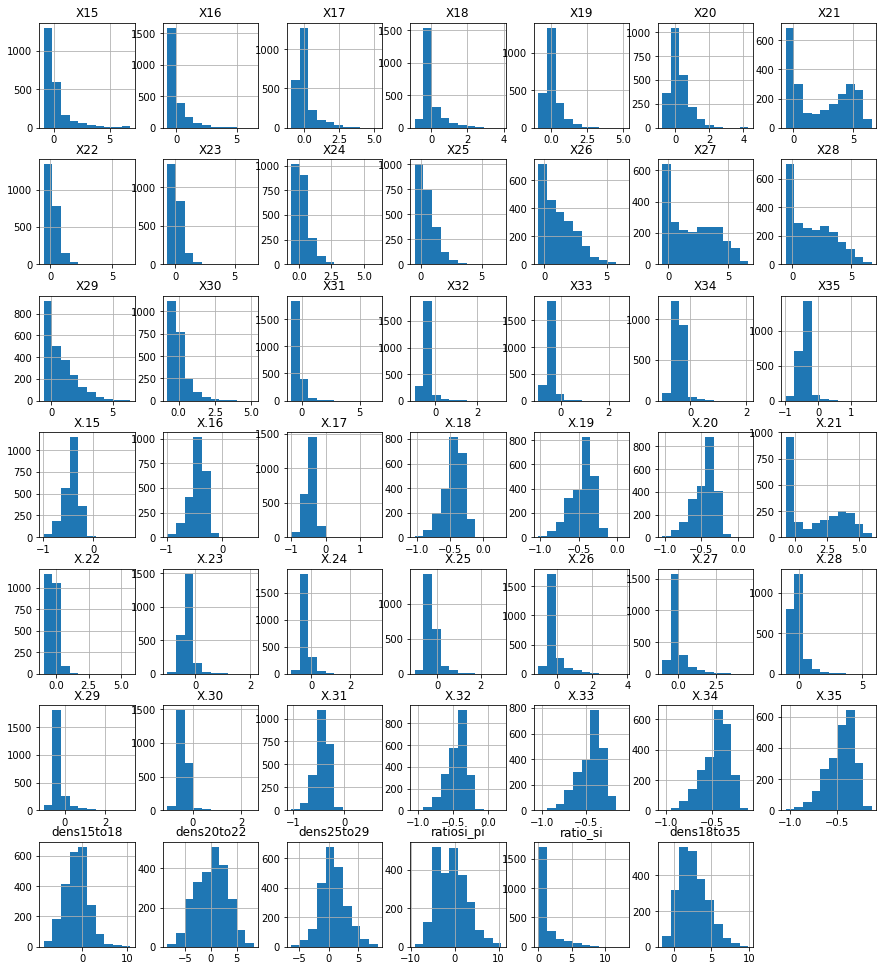

In [ ]:
X.hist(figsize=(15,17))
plt.show()

Visualizando a distribuição dos valores dos atributos separando as classes de iinteresse (y)

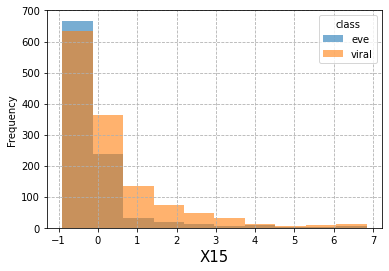

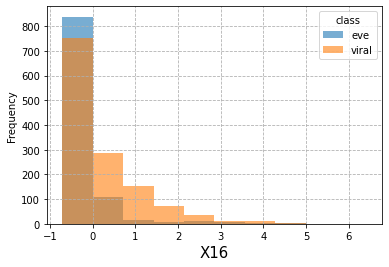

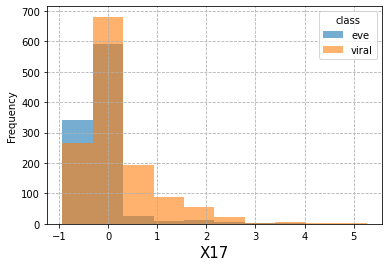

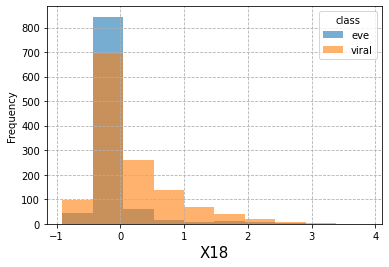

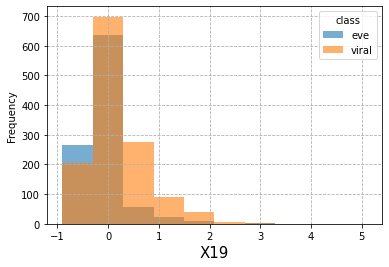

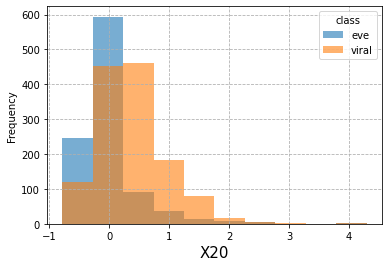

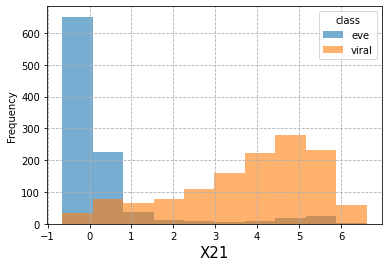

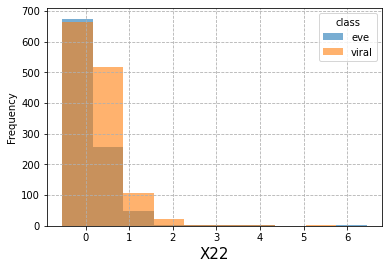

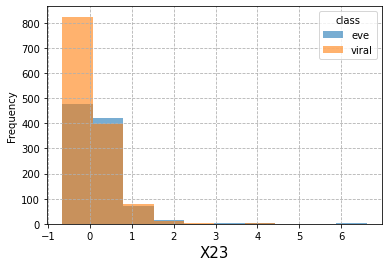

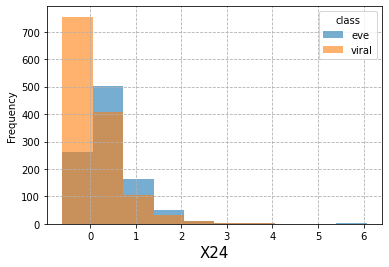

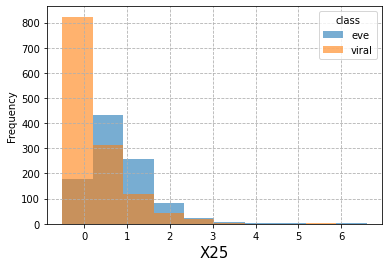

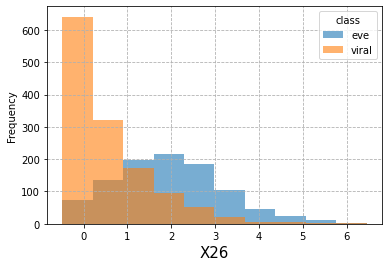

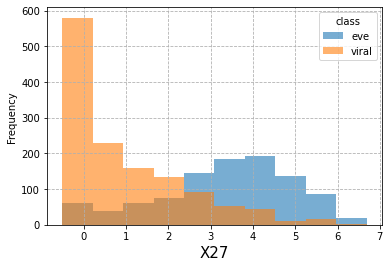

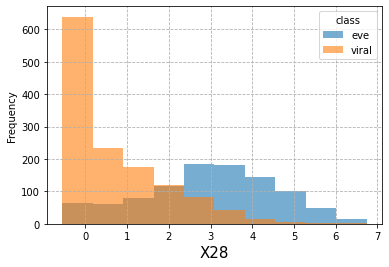

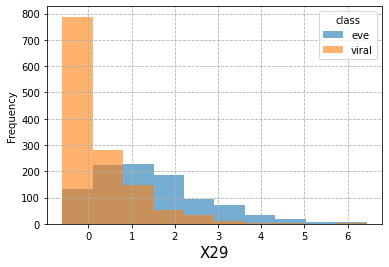

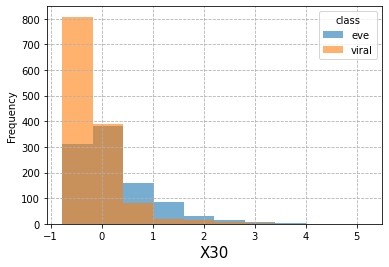

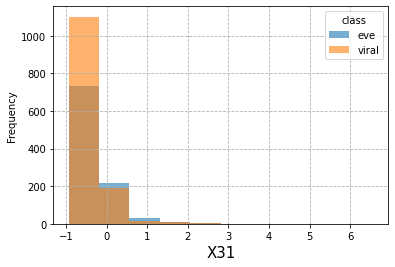

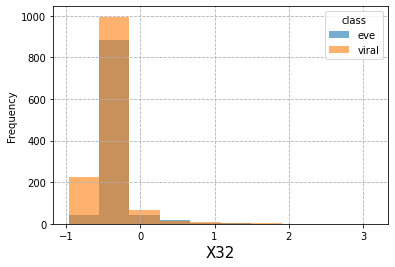

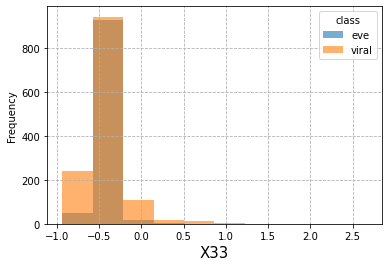

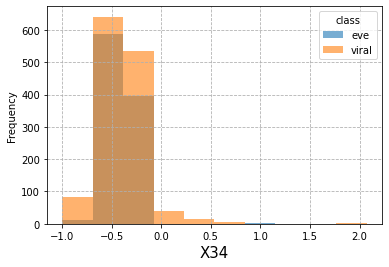

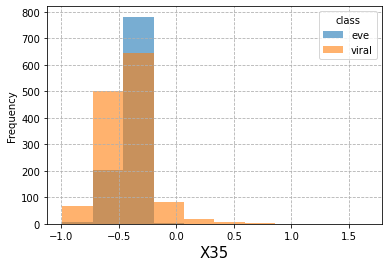

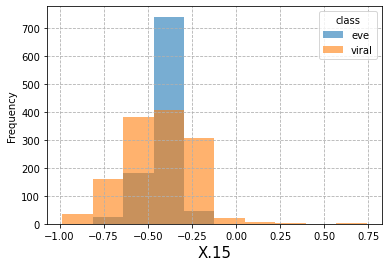

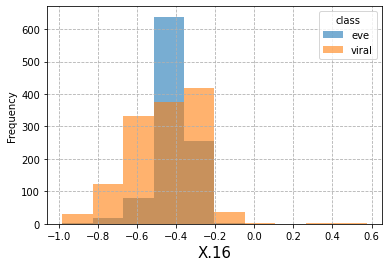

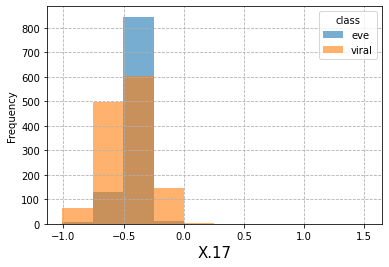

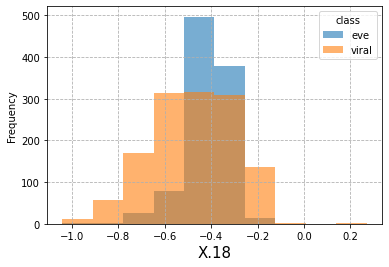

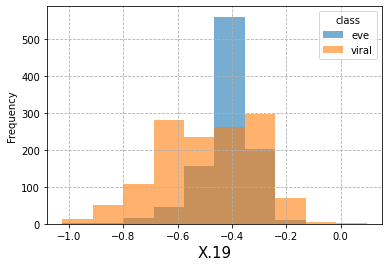

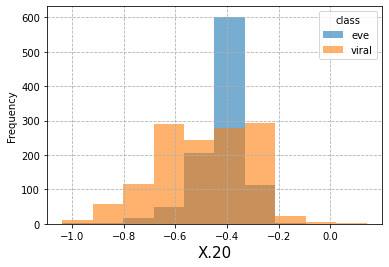

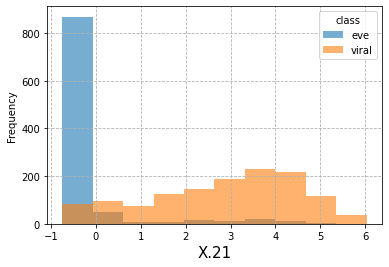

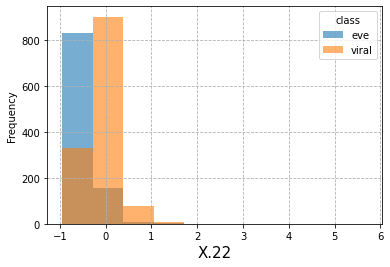

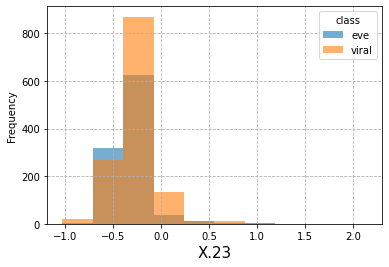

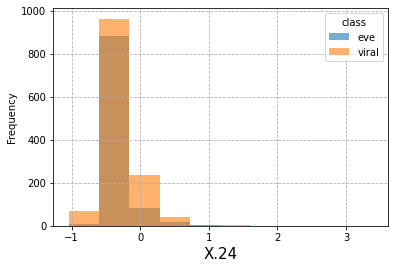

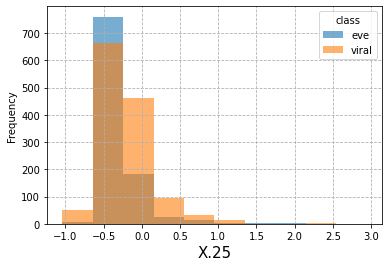

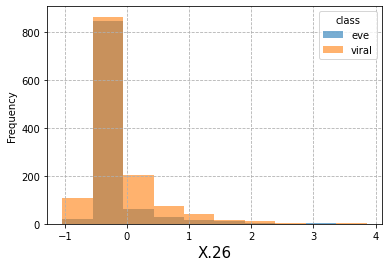

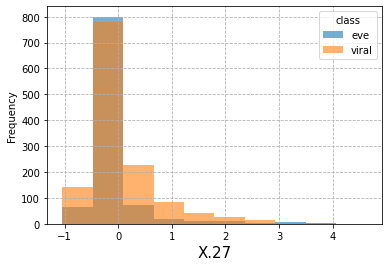

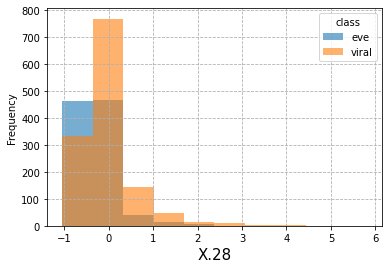

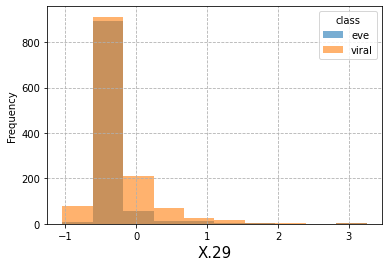

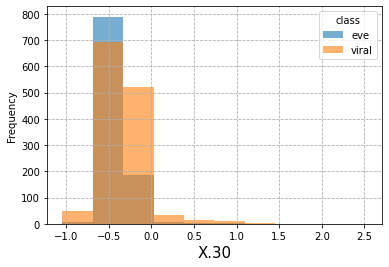

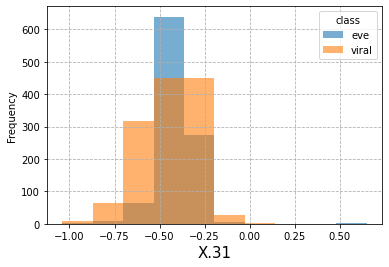

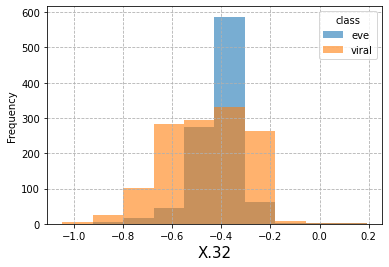

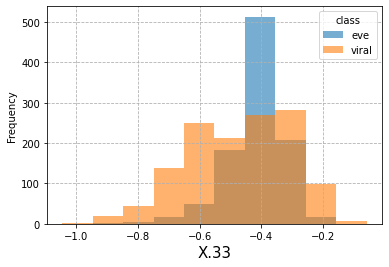

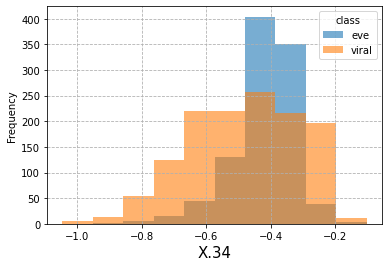

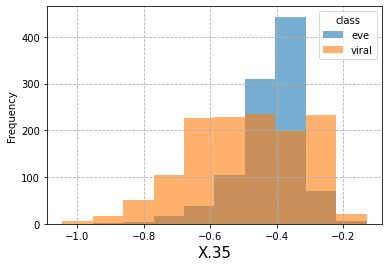

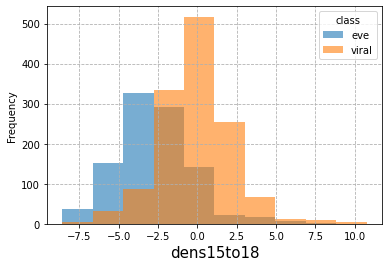

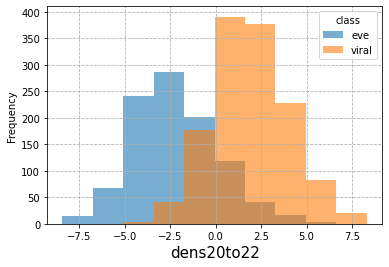

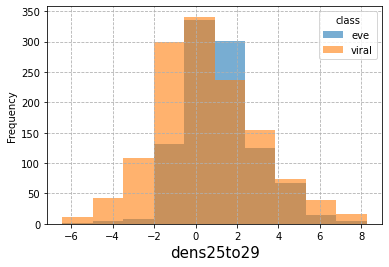

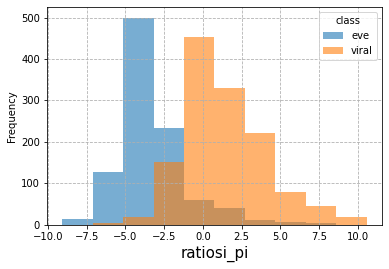

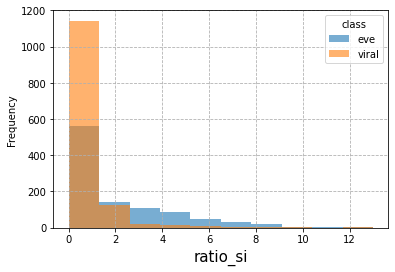

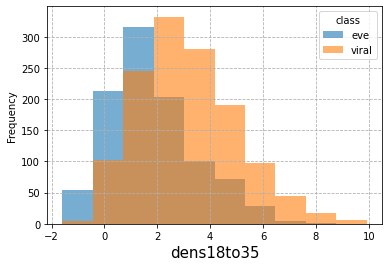

In [ ]:
for i in virus_eves.columns[4:52]:
  virus_eves.pivot(columns='class', values= i).plot.hist(alpha = 0.6)
  plt.xlabel(i, fontdict={'fontsize': 15})
  plt.grid(linestyle="--")
  plt.show()

A analise doa hiatogramas dos atributos considerando as classes "eve" e "viral" evidencia consistência da etapa de "engenharia de atributos"  que realizei com minha ferramenta "small RNA metavir"(https://github.com/JPbio/small_RNA_MetaVir/wiki/small-RNA-Metavir:-small-RNA-reads-for-big-viral-discoveries) . Buscar sinais da interação virus/hospedeiro no mar de moléculas sequenciadas em um experimento de RNA-seq é algo complexo que exige normalizações e processamentos especificas para esses dados. Um exemplo que considero um sucesso são as features "X21" e "X.21" que representam a quantidade normalizada de RNAs de 21 nucleotideos gerados pelo virus interagindo com o mosquito. Sabe-se pela literatura da imunologia de insetos, que altas concentracao de RNAs desse tamanho pode ser evidencia de um virus real interagindo com o hospedeiro, pois eves nao geram RNAs desse tamanho.

Separando os labels (y)

In [ ]:
y = virus_eves['class'] #vetor de rótulos das instâncias
y.shape #conferindo as dimensoes

(2315,)

NameError: ignored

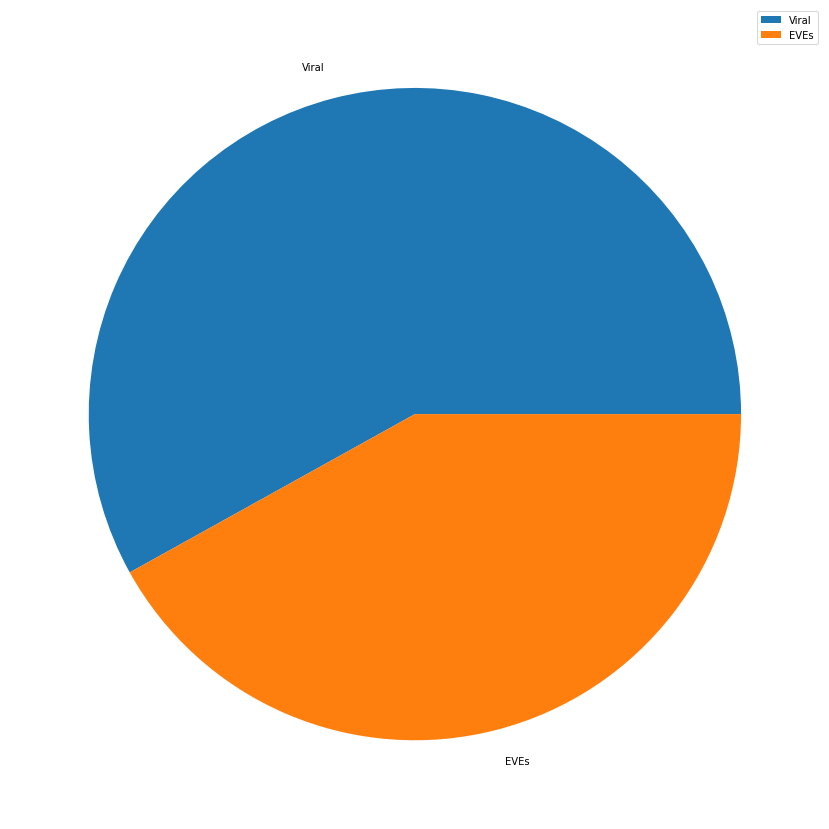

In [ ]:
y.value_counts()

label_counts = np.array([1321,954])
mylabels = ["Viral", "EVEs"]

plt.figure(figsize=(15,15))
plt.pie(label_counts, labels = mylabels)
plt.legend()
plot.legend(loc=2, prop={'size': 10})
plt.show() 





Extratificando os dados em treino e teste:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y) # Reservand 30% das instâncias para teste

X_train.shape, X_test.shape, y_train.shape, y_test.shape #conferindo as dimensões dos extratos de treino e teste


((1620, 48), (695, 48), (1620,), (695,))

Conferindo a presença apenas de dados numéricos na matriz de atributos:

In [ ]:
set(X.dtypes)

{dtype('float64')}

**Normalização dos dados**
A matriz de atributos utilizada nesse trabalho é saída de uma ferramenta que estou construindo no meu doutorado "Small RNA Metavir" (https://github.com/JPbio/small_RNA_MetaVir) para processar dads de RNA-seq em larga escala e "mineirar" sequências virais. As features já sairam do pipeline de mineiração "normalizadas" com calculos que levam em conta peculiaridades das bibliotecas de RNA-seq (dado bruto) e utiliza "Z-score" ao final, tudo aplicado com scripts escritos em R. Portanto, não será necessário realizar normalizações para aplicaões de modelos de aprendizado nesse notebook.

#**2- Aplicação de algoritmos de aprendizado não supervisionados**

Os algoritmos nessa seção foram aplicados para visuazalição dos dados, reduções dimensionais e analises exploratórias da estrutração dos dados em relação as de interesse: "virus" e "eve".

#2.1 *t-Distributed Stochastic Neighbor Embedding (t-SNE)*



In [ ]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns

In [ ]:
tsne = TSNE(n_components=2, verbose=1,random_state=123) #computando o t-SNE
X_tsne = tsne.fit_transform(X) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2315 samples in 0.000s...
[t-SNE] Computed neighbors for 2315 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2315
[t-SNE] Computed conditional probabilities for sample 2000 / 2315
[t-SNE] Computed conditional probabilities for sample 2315 / 2315
[t-SNE] Mean sigma: 1.530579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.068428
[t-SNE] KL divergence after 1000 iterations: 1.071882


[Text(0.5, 1.0, 'Projeção t-SNE sequências virais e eves')]

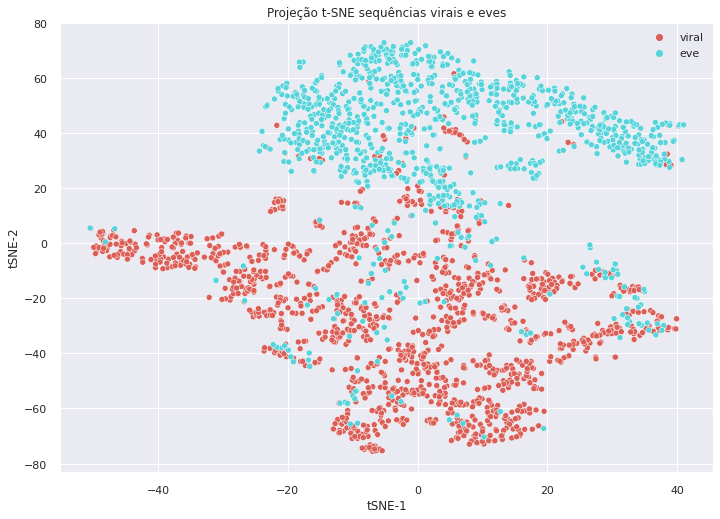

In [ ]:
#Plotando o resultado e 2 dimensões para visualização
aux = pd.DataFrame()
aux["y"] = y
aux["tSNE-1"] = X_tsne[:,0]
aux["tSNE-2"] = X_tsne[:,1]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x="tSNE-1", y="tSNE-2", hue=aux.y.tolist(),
                palette=sns.color_palette("hls",2),
                data=aux).set(title="Projeção t-SNE sequências virais e eves") 

Podemos notar uma certa definição de duas "nuvens de dados" representando as duas classes de interesse nesse trabalho.

# 2.2 *Pincipal Component Analysis (PCA)* 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Computando componentes principais
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

In [ ]:
# Conferindo dimensoes do resultado
print(X_pca.shape)

(2315, 3)


In [ ]:
#Transformacoes dos dataframes apenas para ajustar a vizualizacao
aux1 = pd.DataFrame()
aux1["y"] = y
aux1["PC-1"] = X_pca[:,0]
aux1["PC-2"] = X_pca[:,1]

[Text(0.5, 1.0, 'Iris data T-SNE projection')]

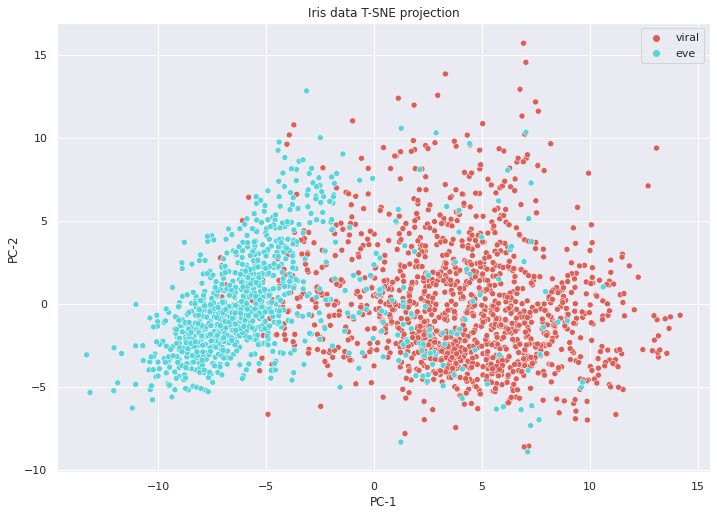

In [ ]:
#Plotando os dados com as duas Principais componentes
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x="PC-1", y="PC-2", hue=aux1.y.tolist(),
                palette=sns.color_palette("hls",2),
                data=aux1).set(title="Iris data T-SNE projection") 

In [ ]:
# COnferindo a porcentagem da variância explicada pelas [PC1,PC2, PC3]
print(100*pca.explained_variance_ratio_)

[54.26340341 18.01306287  7.42823848]


Assim como no t-SNE, podemos notar uma certa definição de duas "nuvens de dados" representando as duas classes de interesse nesse trabalho e com uma relevante porcentagem da variância explicada pela PC1 (~54%)

#2.3 *Hierarchical Clustering* 

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
# Computando as distâncias 
Z = linkage(X, method= 'ward', metric= 'euclidean')  #Método e métricas definidos arbitrariamente de acordo com minha experiência com esse tipo de dados de RNA-seq

In [ ]:
#Contruindo o dendograma 
dendrogram(Z, labels=y, leaf_rotation=0, orientation="left", color_threshold=150,above_threshold_color='grey', truncate_mode = 'lastp', p=20)
plt.axvline(x=150 , c='grey', lw=1, linestyle='dashed')
plt.title('Agrupamento Hierárquico usando método ward e distância euclidiana', fontdict={'fontsize': 20})
plt.xlabel('Distância', fontdict={'fontsize': 15})
plt.ylabel('Sequências', fontdict={'fontsize': 15})
plt.show()

Acima gerei uma visualização colapsada dos clusters gerados apenas para ter uma percepção geral do resultado. Podemos notar uma definição de 2 grandes grupos.

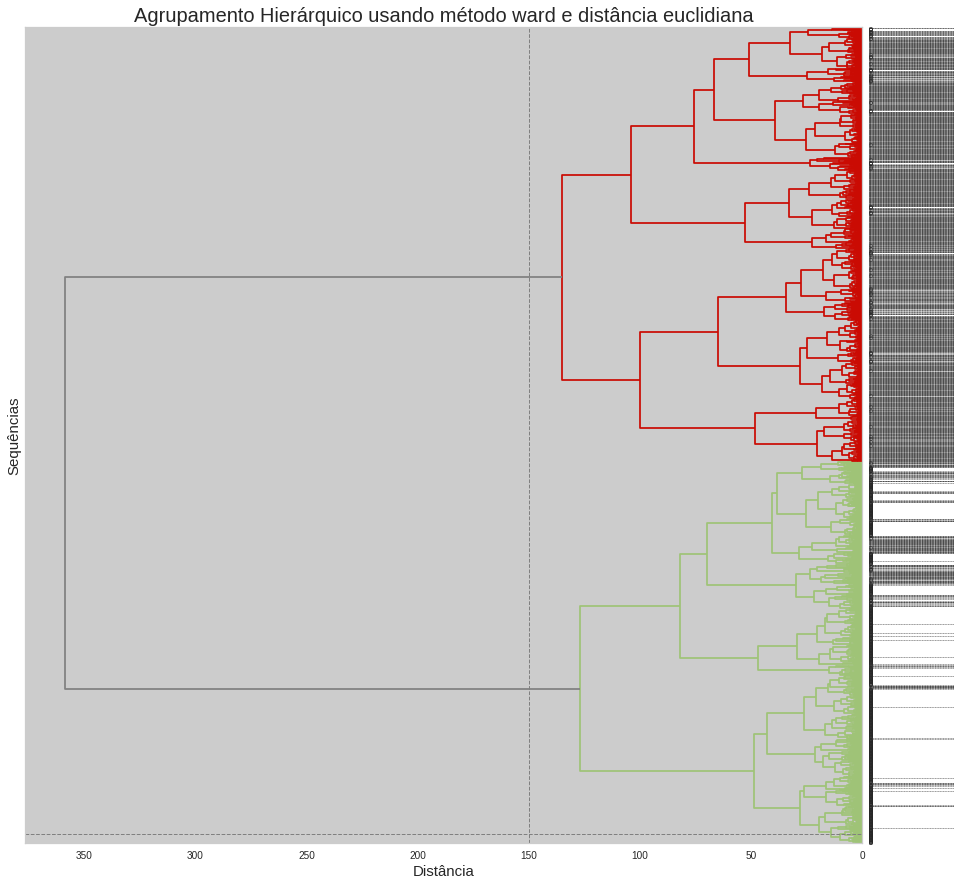

In [ ]:
#Nao consegui achar uma forma de colorir os labels, por isso vou improvisar a vizualização a baixo, onde o label com um tracejado longo representa as sequencias vitais na figura
y_gamblabels = y.replace(['viral','eve'],['-----------------------------------------------------','O'])

#Dendograma com visualizacao improvisada para conferir a organizacao das sequencias virais e eves nos clusters
plt.figure(figsize=(15,15)) 
dendrogram(Z, labels=y_gamblabels, leaf_rotation=0, orientation="left", color_threshold=150, above_threshold_color='grey')
plt.axvline(x=150 , c='grey', lw=1, linestyle='dashed')
plt.title('Agrupamento Hierárquico usando método ward e distância euclidiana', fontdict={'fontsize': 20})
plt.axhline(y=240, c='grey', lw=1, linestyle='dashed')
plt.xlabel('Distância', fontdict={'fontsize': 15})
plt.ylabel('Sequências', fontdict={'fontsize': 15})
plt.show()

####################

Podemos notar que o grande agrupamento suérior é composto, em sua absoluta maioria, por sequências da classe "viral". Temos uma clusterização hieráquica consistente com a hipótese de que os atributos usadas nesse trabalho podem separa virus de eves.

# 2.4 *Agglomerative Clustering* 

In [ ]:
from sklearn.cluster import AgglomerativeClustering

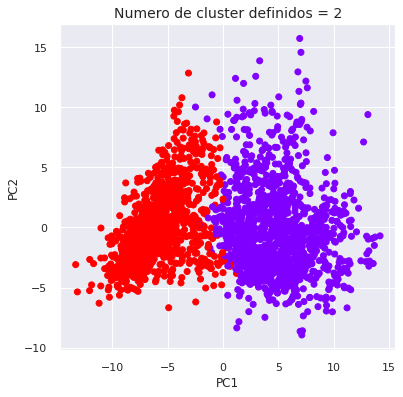

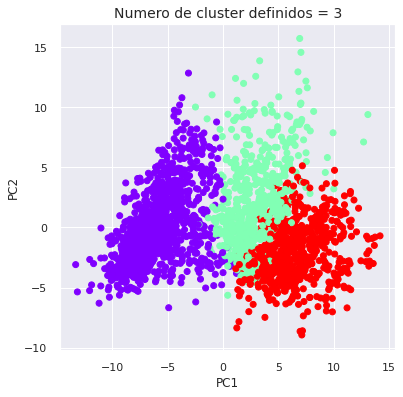

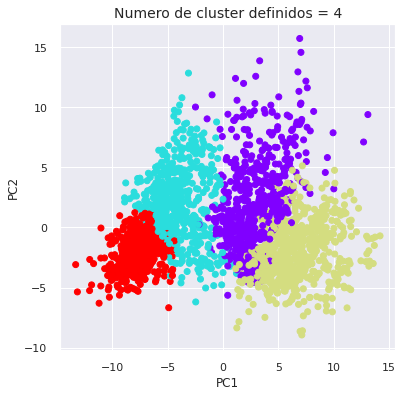

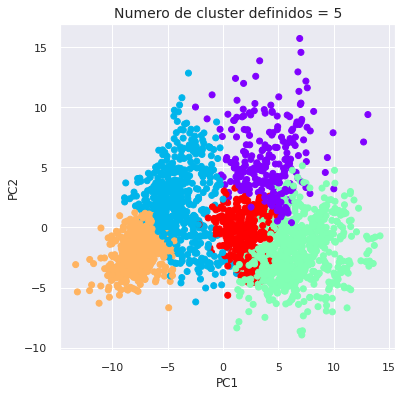

In [ ]:
#Aqui estou empregando uma outra clusterização visualização de potenciais agrupamentos utilizando um algoritmo aglomerativo
# aqui a definição de clusters é arbitraria e testarei algumas variações
#Para possibilitar a visuzalição em 2d dos clusters determinados, estou usando as PC-1 e 2 computados na PCA realizada anteriormente

#Nesse loop vou criar os modelos e computar a clusterização considerando diferentes numeros de clusters e plotar a inferência dos clusters no resultado da PCA (PCs 1 e 2) 
for i in list(range(2,6)):
    ac = locals()["x" + str(i)] = AgglomerativeClustering(n_clusters = i, linkage="ward")
    # Visualizing the clustering
    plt.figure(figsize =(6, 6))
    plt.scatter(X_pca[:,0], X_pca[:,1],c = ac.fit_predict(x), cmap ='rainbow')
    plt.title('Numero de cluster definidos = %i' %i, fontdict={'fontsize': 14})
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()



Para uma inferência do melhor número de clusters utilizando algum critério matemático avaliarei os "*Silhouette Scores*". Quanto mais próximo de **1**, melhor efinidos são os cluters.

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
k = [2, 3, 4, 5] # arrumando para o plot

#Calculando o "silhouette score" para os modelos aglomerativos criados com diferentes numeros de clusters que gerei anteriormente
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(x, x2.fit_predict(x)))
silhouette_scores.append(
        silhouette_score(x, x3.fit_predict(x)))
silhouette_scores.append(
        silhouette_score(x, x4.fit_predict(x)))
silhouette_scores.append(
        silhouette_score(x, x5.fit_predict(x)))

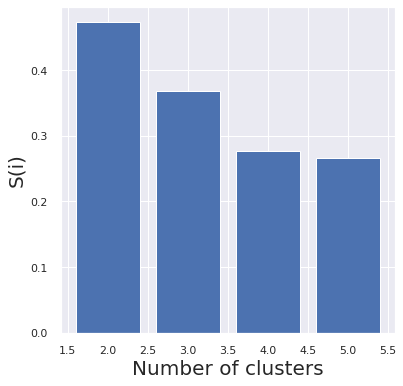

In [ ]:
# Plotando grafico de barras para comprar os resultados dos "silhouette scores"
plt.figure(figsize =(6, 6))
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

COnsiderando os "Silhouette Scores",  o número de clusters = 2 é o que gerou os clusters melhores definidos. Consistente com a hipótese de que as features usadas para descrever sequências virais nesse trabalho separão bem virus de eves.  

# 2.5 *K-Means* 

In [ ]:
pip install kneed

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


Avaliarei a "SSE curve" (sum of the squared Euclidean distances) com a finalidade de escoher o melhor valor de k. 
O que buscamos aqui é o "cotovelo de uma curva", onde há um ótimo "trade-off" do número de k e do score avaliado. Porém essa tarefa pode ser subjetiva. Podeos tentar inferir esse ponto ótimo ""
Podemos usar funções prontas que ajudam na inspeção da curva e decisão do melhor k.


In [ ]:
from yellowbrick.cluster import KElbowVisualizer

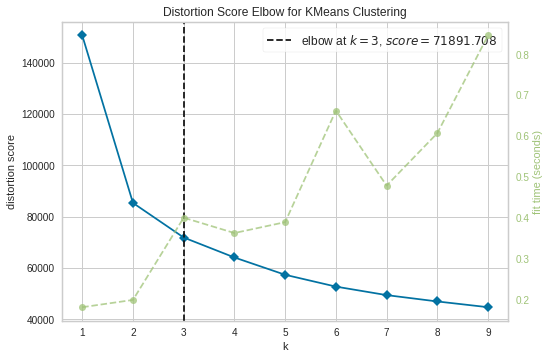

In [ ]:
kmeans_kwargs = {
        "init": "k-means++", #inicializacao nao aletoria dos centroides com k-means++
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,}


model = KMeans(**kmeans_kwargs)
visualizer = KElbowVisualizer(model, k=(1,10)).fit(X) #avaliando k de 1 a 10
visualizer.show()

Apenas para conferir, vou verificar a inferência do valor ótimo de k considerando o dado X reduzido para 3 componentes principais (X_pca)

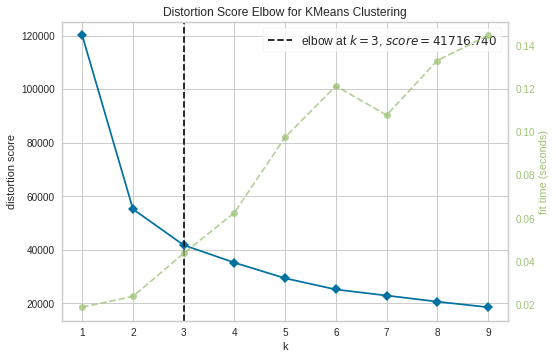

In [ ]:
kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,}


model = KMeans(**kmeans_kwargs)
visualizer = KElbowVisualizer(model, k=(1,10)).fit(X_pca)
visualizer.show()

O valor de k inferido para ambas respresentações dos dados, foi 3. Agora vou visualizar os clusters definidos com k=3 nas representação da PCA em 2d

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs).fit(X) # computando kmeans novamente agora que tenho meu k "ótimo" inferido

Contando quantas observações foram classificadas em cada um dos 3 clusters

In [ ]:
#Get each cluster size,
from collections import Counter
Counter(kmeans.labels_)


Counter({0: 868, 1: 958, 2: 489})

Visualizando os clusters

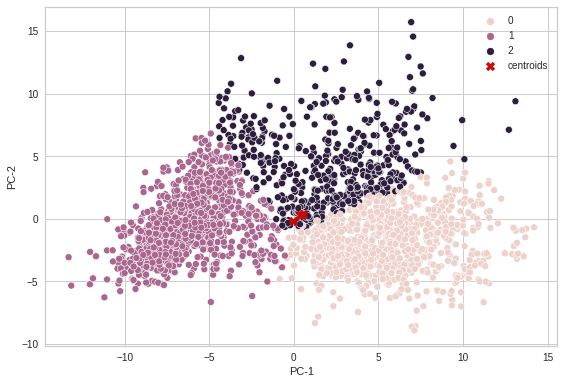

In [ ]:
sns.scatterplot(data=aux1, x="PC-1", y="PC-2", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            marker="X", c="r", s=80, label="centroids")
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.show()


A aplicação do k-Means sugere a exitência de três grupos nos meus dados. Porém, nitidamente, não parece uma divisão de clusters nitida, mesmo com o k ótimo, os pontos estão bastante próximos. A possibilidade de 3 grupos nesses dados é algo que explorarei no futuro.

#**3- Experimentos com modelos de aprendizado supervisionado**

Para as variações de hiperparâmetros, avaliação dos métodos com k-fold (k=5) e calculo de acúracia automático dos modelos avaliados para cada método utilizarei o método "*GridSearchCV()*" .

*   Hiperparâmetros modificados foram armazenados em 'param_grid';
*   k-fold (k=5) estabelecido com o parametro "cv=5";
*   Calculo e avaliação de acurácia instânteneo de todos modelos determinado por "scoring='accuracy'".






# 3.1- *Naive Bayes*



Importando biblioteca para aplicação do modelo: 

In [ ]:
from sklearn.naive_bayes import GaussianNB

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
param_grid = {'clf__var_smoothing': np.logspace(0,-9,num=100)}

NB_model = Pipeline( steps=[("clf", GaussianNB())])

NB_grid = GridSearchCV(
    estimator=NB_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)


Treinando o modelo:

In [ ]:
NB_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', GaussianNB())]),
             param_grid={'clf__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.5...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
NB_grid_table = pd.DataFrame(NB_grid.cv_results_)
NB_grid_table.head()

Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of smoothing = {} with {} of accuracy.".format(NB_grid.best_params_,NB_grid.best_score_))

The best value of smoothing = {'clf__var_smoothing': 3.511191734215127e-05} with 0.8938271604938273 of accuracy.


Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
NB_grid_predictions = NB_grid.predict(X_test) #Predição da classe (y) dos dados de teste com o melhor modelo selecionado
 
print(classification_report(y_test, NB_grid_predictions))# Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.86      0.85      0.86       298
       viral       0.89      0.90      0.89       397

    accuracy                           0.88       695
   macro avg       0.88      0.87      0.88       695
weighted avg       0.88      0.88      0.88       695



# 3.2- *Decision Tree*

Importando biblioteca para aplicação do modelo:

In [ ]:
from sklearn import tree

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
param_grid = {
    'clf__max_depth': np.arange(start=3, stop=100, step=3)} 

DT_model = Pipeline(
    steps=[
        
        ("clf", tree.DecisionTreeClassifier())
    ]
)

DT_grid = GridSearchCV(
    estimator=DT_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)



Treinando o modelo:

In [ ]:
DT_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf', DecisionTreeClassifier())]),
             param_grid={'clf__max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
       54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
DT_grid_table = pd.DataFrame(DT_grid.cv_results_)
DT_grid_table.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.052466,0.011766,0.010629,0.004698,3,{'clf__max_depth': 3},0.907407,0.907407,0.907407,0.898148,...,0.907407,0.005856,1,0.934414,0.933642,0.934414,0.922068,0.924383,0.929784,0.005412
1,0.074068,0.007012,0.004484,0.000053,6,{'clf__max_depth': 6},0.910494,0.885802,0.907407,0.898148,...,0.904321,0.011548,2,0.969136,0.970679,0.963735,0.959105,0.972222,0.966975,0.004865
2,0.112495,0.017346,0.007982,0.006046,9,{'clf__max_depth': 9},0.895062,0.891975,0.919753,0.888889,...,0.901852,0.012407,3,0.989198,0.982253,0.983796,0.980710,0.991512,0.985494,0.004152
3,0.126487,0.027167,0.007947,0.004909,12,{'clf__max_depth': 12},0.879630,0.873457,0.907407,0.870370,...,0.886420,0.015045,29,0.997685,0.993056,0.993056,0.991512,1.000000,0.995062,0.003222
4,0.151382,0.034842,0.008646,0.004046,15,{'clf__max_depth': 15},0.888889,0.879630,0.891975,0.885802,...,0.891358,0.010403,12,1.000000,0.996914,1.000000,0.993056,1.000000,0.997994,0.002743


Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of  {}  with {} of accuracy.".format(DT_grid.best_params_,DT_grid.best_score_))

The best value of  {'clf__max_depth': 3}  with 0.9074074074074074 of accuracy.


Plotando curva com os valores de erros estimado
(1- media da acuracia) no conjunto de treino e de teste da validação cruzada.

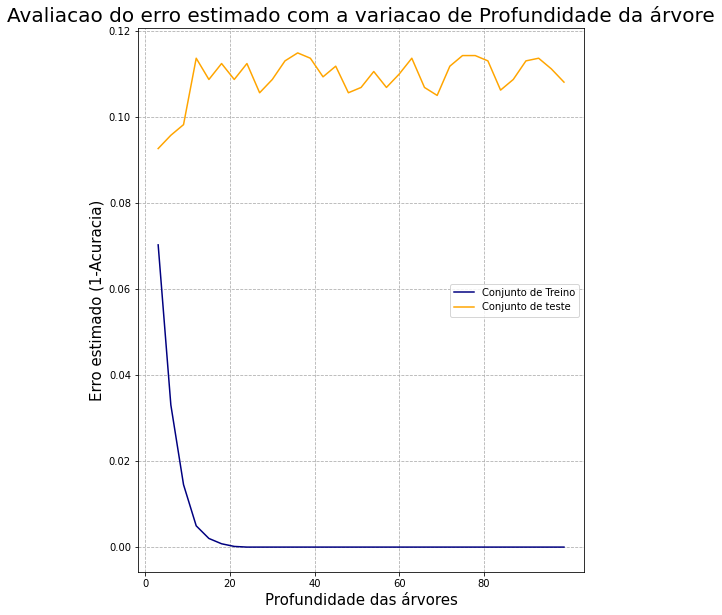

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(DT_grid.cv_results_['param_clf__max_depth'],1-DT_grid.cv_results_['mean_train_score'],
         color='navy', label="Conjunto de Treino")
plt.plot(DT_grid.cv_results_['param_clf__max_depth'],1-DT_grid.cv_results_['mean_test_score'],
         color='orange',label="Conjunto de teste")
plt.xlabel('Profundidade das árvores', fontdict={'fontsize': 15})
plt.ylabel('Erro estimado (1-Acuracia)', fontdict={'fontsize': 15})
plt.title('Avaliacao do erro estimado com a variacao de Profundidade da árvore', fontdict={'fontsize': 20})
plt.xticks(range(0,100,20),)
plt.legend(loc='best')
plt.grid(linestyle="--")
plt.show()

Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
DT_grid_predictions = DT_grid.predict(X_test)#Predição da classe (y) dos dados de teste com o melhor modelo selecionado
 
print(classification_report(y_test, DT_grid_predictions))#Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.95      0.85      0.90       298
       viral       0.89      0.96      0.93       397

    accuracy                           0.92       695
   macro avg       0.92      0.91      0.91       695
weighted avg       0.92      0.92      0.91       695



Visualização geral do modelo com a profundidade que resultou na melhor acurácia 

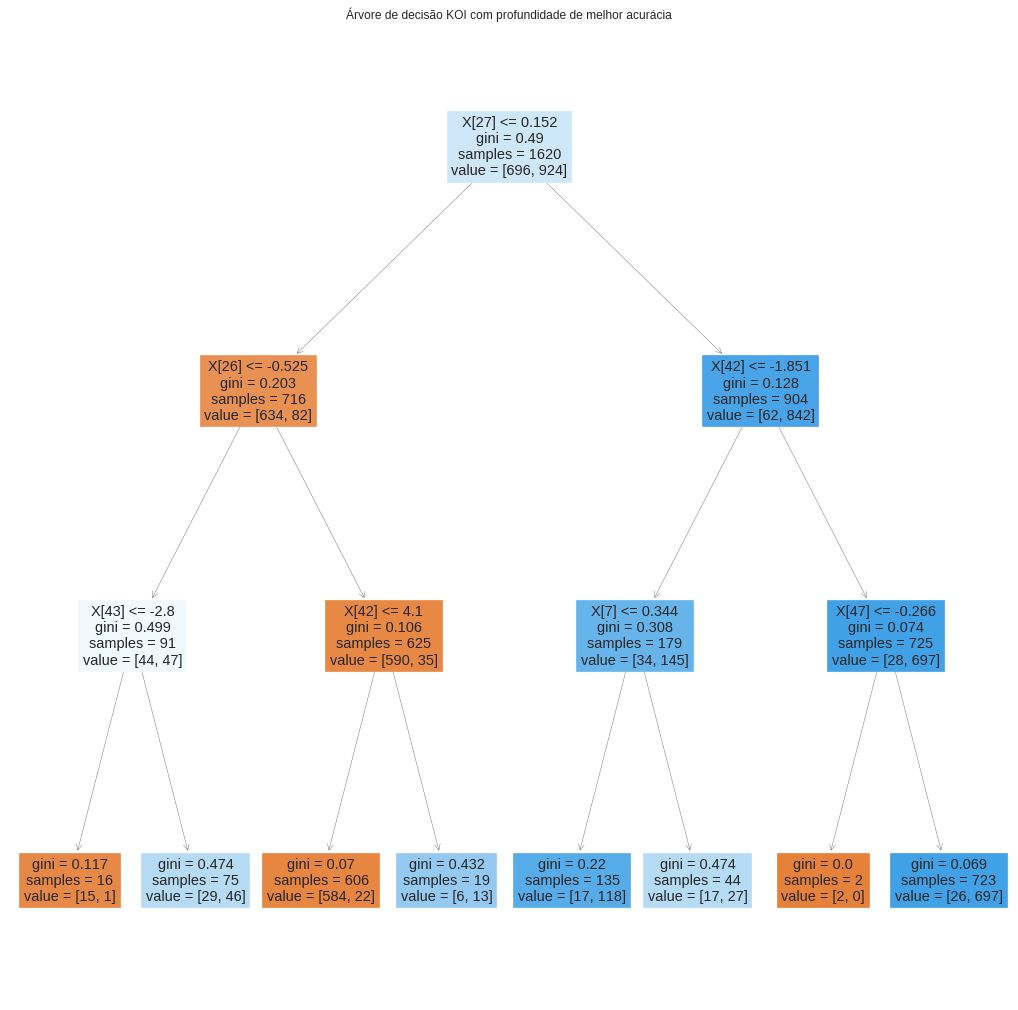

In [ ]:
plt.figure(figsize=(18,18))
tree.plot_tree(DT_grid.best_estimator_["clf"], filled=True)
plt.title("Árvore de decisão KOI com profundidade de melhor acurácia")
plt.show()

In [ ]:
X.columns[47]

'dens18to35'

Inspecionando qual foi o atributo que iniciou a árvore com melhor acurácia 

In [ ]:
X.columns[27]

'X.21'

Muito interessante, foi a quantidade de RNAs de 21 nucleotídeos da fita antisense, uma molécula de relevância bioquimica para a infecção viral. Como de se esperar de um modelo simples como uma árvore de decisão, a interpretabilidade foi alta.

# 3.3- *Support Vector Machines*

Importando biblioteca para aplicação do modelo:

In [ ]:
from sklearn.svm import SVC

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
# defining parameter range
param_grid = {'clf__kernel': ["poly","linear","rbf","sigmoid"],
              'clf__degree' : [2,3,4,5,6]}



SVM_model = Pipeline(
    steps=[
       
        ("clf", SVC())
    ]
)

SVM_grid = GridSearchCV(
    estimator=SVM_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy')


Treinando o modelo:

In [ ]:
SVM_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', SVC())]),
             param_grid={'clf__degree': [2, 3, 4, 5, 6],
                         'clf__kernel': ['poly', 'linear', 'rbf', 'sigmoid']},
             scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
SVM_grid_table = pd.DataFrame(SVM_grid.cv_results_)
SVM_grid_table.head()

Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of {} with {} of accuracy.".format(SVM_grid.best_params_,SVM_grid.best_score_))

The best value of {'clf__degree': 4, 'clf__kernel': 'poly'} with 0.9191358024691357 of accuracy.


Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
SVM_grid_predictions = SVM_grid.predict(X_test)#Predição da classe (y) dos dados de teste com o melhor modelo selecionado
 
print(classification_report(y_test, SVM_grid_predictions))# Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.95      0.84      0.89       298
       viral       0.89      0.97      0.93       397

    accuracy                           0.91       695
   macro avg       0.92      0.90      0.91       695
weighted avg       0.92      0.91      0.91       695



# 3.4- *k-Nearest Neighbors*

Importando biblioteca para aplicação do modelo:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
param_grid = {'clf__n_neighbors' : np.arange(start=3, stop=100, step=3)}

kNN_model = Pipeline(
    steps=[
       
        ("clf", KNeighborsClassifier())
    ]
)

kNN_grid = GridSearchCV(
    estimator=kNN_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)


Treinando o modelo:

In [ ]:
kNN_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': array([ 3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
       54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
grid_table = pd.DataFrame(kNN_grid.cv_results_)
grid_table.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005910,0.000474,0.028448,0.003393,3,{'clf__n_neighbors': 3},0.904321,0.895062,0.938272,0.910494,...,0.916667,0.017129,1,0.949074,0.949074,0.942901,0.940586,0.941358,0.944599,0.003729
1,0.008414,0.004308,0.028151,0.000437,6,{'clf__n_neighbors': 6},0.891975,0.895062,0.932099,0.916667,...,0.913580,0.017350,5,0.939043,0.937500,0.924383,0.923611,0.928241,0.930556,0.006511
2,0.006228,0.000178,0.028155,0.000155,9,{'clf__n_neighbors': 9},0.910494,0.888889,0.935185,0.907407,...,0.915432,0.017741,2,0.931327,0.932870,0.923611,0.923611,0.925926,0.927469,0.003904
3,0.006277,0.000456,0.032127,0.005011,12,{'clf__n_neighbors': 12},0.910494,0.895062,0.935185,0.907407,...,0.914198,0.013720,3,0.929012,0.927469,0.915895,0.918210,0.921296,0.922377,0.005109
4,0.006196,0.000228,0.031060,0.005132,15,{'clf__n_neighbors': 15},0.907407,0.891975,0.929012,0.910494,...,0.913580,0.014076,4,0.923611,0.927469,0.914352,0.915895,0.918981,0.920062,0.004870


Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of k = {} with {} of accuracy.".format(kNN_grid.best_params_,kNN_grid.best_score_))

The best value of k = {'clf__n_neighbors': 3} with 0.9166666666666666 of accuracy.


Plotando curva com os valores de erros estimado
(1- media da acuracia) no conjunto de treino e de teste da validação cruzada.

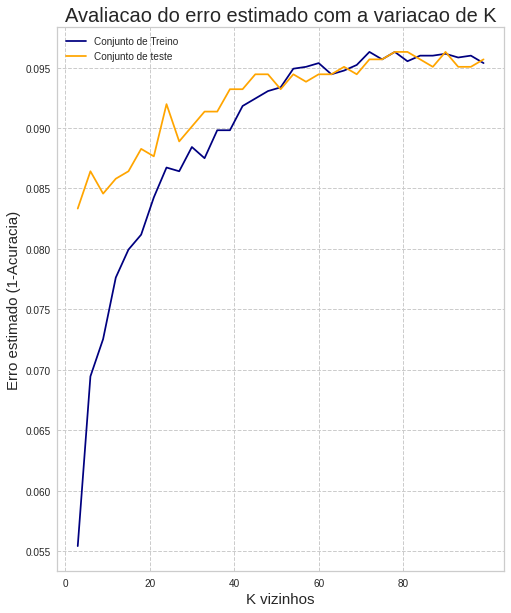

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(kNN_grid.cv_results_['param_clf__n_neighbors'],1-kNN_grid.cv_results_['mean_train_score'],
         color='navy', label="Conjunto de Treino")
plt.plot(kNN_grid.cv_results_['param_clf__n_neighbors'],1-kNN_grid.cv_results_['mean_test_score'],
         color='orange',label="Conjunto de teste")
plt.xlabel('K vizinhos', fontdict={'fontsize': 15})
plt.ylabel('Erro estimado (1-Acuracia)', fontdict={'fontsize': 15})
plt.title('Avaliacao do erro estimado com a variacao de K', fontdict={'fontsize': 20})
plt.xticks(range(0,100,20),)
plt.legend(loc='best')
plt.grid(linestyle="--")
plt.show()

Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
kNN_grid_predictions = kNN_grid.predict(X_test) #Predição da classe (y) dos dados de teste com o melhor modelo selecionado
 
print(classification_report(y_test, kNN_grid_predictions))# Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.94      0.87      0.90       298
       viral       0.91      0.96      0.93       397

    accuracy                           0.92       695
   macro avg       0.92      0.91      0.92       695
weighted avg       0.92      0.92      0.92       695



#**3.5- *Ensemble models***

Foi discutido nessa disciplina que o "estado da arte" do aprendizado supervisionado para lidar com problemas de classificação com dados estruturas são os modelos ensamble. No caso do meu problema, eles são ainda mais relevantes, por que eu tenho poucos dados, es estou em uma área perigosa de risco de "overfitting", o que pode ser até certo ponto, combatido com bagging (lida com erro de variância) e boosting (lida com erro de viés).

Em algum momento, eu poderia cogitar alguma abordam de NLP, já que tenho minhas sequências de RNAs montadas, porém, nas minhas estimativas mais otimistas de recursos financeiros e poder de mineiração de dados publicos que tenho até o final do doutorado, dificilmente conseguirei mais de 3 mil exemplos para cada uma de minhas classes eves e viral. Por isso, meu enfoque nos ensembles para meu problema.





#3.5.1- *Random Forest*

Importando biblioteca para aplicação do modelo:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
####
# 
param_grid = {'clf__n_estimators' : np.arange(start=50, stop=500, step=50)}

RF_model = Pipeline( steps=[
           ("clf", RandomForestClassifier())
    ]
)

RF_grid = GridSearchCV(
    estimator=RF_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)



Treinando o modelo:

In [ ]:
RF_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
             param_grid={'clf__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
RF_grid_table = pd.DataFrame(RF_grid.cv_results_)
RF_grid_table.head()

Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of {} with {} of accuracy.".format(RF_grid.best_params_,RF_grid.best_score_))

The best value of {'clf__n_estimators': 400} with 0.9283950617283951 of accuracy.


Plotando curva com os valores de erros estimado
(1- media da acuracia) no conjunto de treino e de teste da validação cruzada.

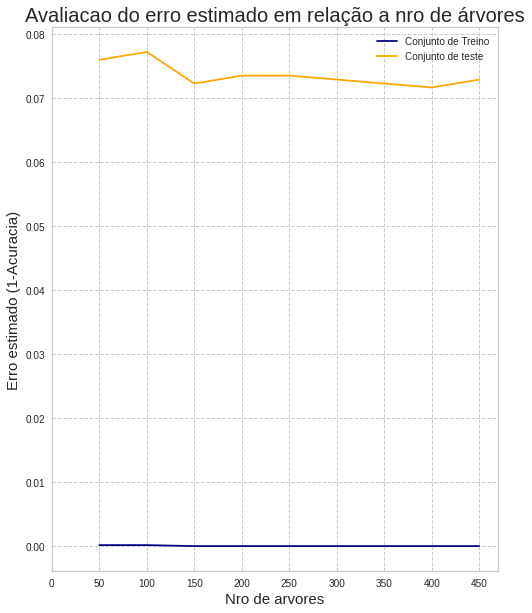

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(RF_grid.cv_results_['param_clf__n_estimators'],1-RF_grid.cv_results_['mean_train_score'],
         color='navy', label="Conjunto de Treino")
plt.plot(RF_grid.cv_results_['param_clf__n_estimators'],1-RF_grid.cv_results_['mean_test_score'],
         color='orange',label="Conjunto de teste")
plt.xlabel('Nro de arvores', fontdict={'fontsize': 15})
plt.ylabel('Erro estimado (1-Acuracia)', fontdict={'fontsize': 15})
plt.title('Avaliacao do erro estimado em relação a nro de árvores', fontdict={'fontsize': 20})
plt.xticks(range(0,500,50),)
plt.legend(loc='best')
plt.grid(linestyle="--")
plt.show()

Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
RF_grid_predictions = RF_grid.predict(X_test)#Predição da classe (y) dos dados de teste com o melhor modelo selecionado
  
print(classification_report(y_test, RF_grid_predictions))# Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.96      0.87      0.91       298
       viral       0.91      0.97      0.94       397

    accuracy                           0.93       695
   macro avg       0.93      0.92      0.92       695
weighted avg       0.93      0.93      0.93       695



#3.5.2- *Adaptative Boosting*






Importando biblioteca do "scikit-learn"

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold (k=5) e computação da acurácia com GridSearchCV():

In [ ]:
param_grid = {
    'clf__n_estimators': np.arange(start=50, stop=500, step=50)} 

AB_model = Pipeline(
    steps=[("clf", AdaBoostClassifier())])

AB_grid = GridSearchCV(
    estimator=AB_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)


Treinando o modelo

In [ ]:
AB_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', AdaBoostClassifier())]),
             param_grid={'clf__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
AB_grid_table = pd.DataFrame(AB_grid.cv_results_)
AB_grid_table.head()

Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of  {}  with {} of accuracy.".format(AB_grid.best_params_,AB_grid.best_score_))

The best value of  {'clf__n_estimators': 200}  with 0.9154320987654321 of accuracy.


Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

Plotando curva com os valores de erros estimado
(1- media da acuracia) no conjunto de treino e de teste da validação cruzada.

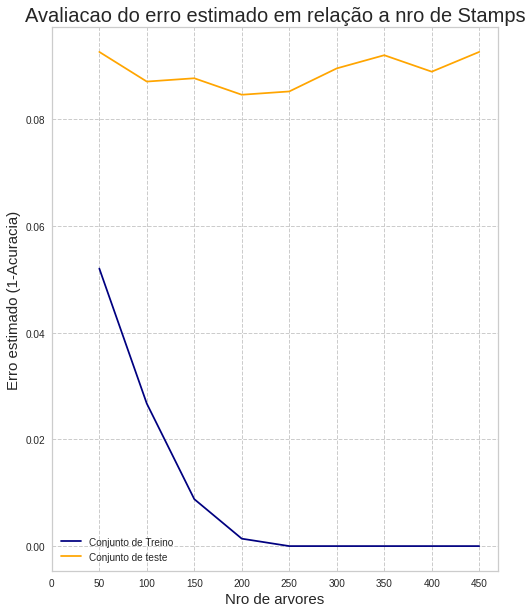

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(AB_grid.cv_results_['param_clf__n_estimators'],1-AB_grid.cv_results_['mean_train_score'],
         color='navy', label="Conjunto de Treino")
plt.plot(AB_grid.cv_results_['param_clf__n_estimators'],1-AB_grid.cv_results_['mean_test_score'],
         color='orange',label="Conjunto de teste")
plt.xlabel('Nro de arvores', fontdict={'fontsize': 15})
plt.ylabel('Erro estimado (1-Acuracia)', fontdict={'fontsize': 15})
plt.title('Avaliacao do erro estimado em relação a nro de Stamps', fontdict={'fontsize': 20})
plt.xticks(range(0,500,50),)
plt.legend(loc='best')
plt.grid(linestyle="--")
plt.show()

In [ ]:
AB_grid_predictions = AB_grid.predict(X_test)#Predição da classe (y) dos dados de teste com o melhor modelo selecionado
print(classification_report(y_test, AB_grid_predictions))#Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.94      0.87      0.90       298
       viral       0.91      0.96      0.93       397

    accuracy                           0.92       695
   macro avg       0.92      0.91      0.92       695
weighted avg       0.92      0.92      0.92       695



#3.5.3- *Gradient Tree Boosting*

Importando biblioteca para aplicação do modelo:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
param_grid = {'clf__n_estimators' : np.arange(start=50, stop=500, step=50)}

GTB_model = Pipeline( steps=[
        ("clf", GradientBoostingClassifier())
    ]
)

GTB_grid = GridSearchCV(
    estimator=GTB_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)


Treinando o modelo

In [ ]:
GTB_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf', GradientBoostingClassifier())]),
             param_grid={'clf__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
grid_table = pd.DataFrame(GTB_grid.cv_results_)
grid_table.head()

Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of {} with {} of accuracy.".format(GTB_grid.best_params_,GTB_grid.best_score_))

The best value of {'clf__n_estimators': 50} with 0.9197530864197532 of accuracy.


Plotando curva com os valores de erros estimado (1- media da acuracia) no conjunto de treino e de teste da validação cruzada.

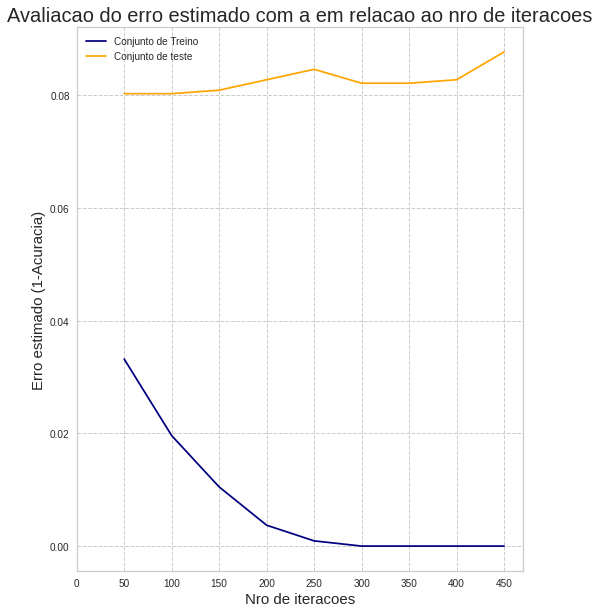

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(GTB_grid.cv_results_['param_clf__n_estimators'],1-GTB_grid.cv_results_['mean_train_score'],
         color='navy', label="Conjunto de Treino")
plt.plot(GTB_grid.cv_results_['param_clf__n_estimators'],1-GTB_grid.cv_results_['mean_test_score'],
         color='orange',label="Conjunto de teste")
plt.xlabel('Nro de iteracoes', fontdict={'fontsize': 15})
plt.ylabel('Erro estimado (1-Acuracia)', fontdict={'fontsize': 15})
plt.title('Avaliacao do erro estimado com a em relacao ao nro de iteracoes', fontdict={'fontsize': 20})
plt.xticks(range(0,500,50),)
plt.legend(loc='best')
plt.grid(linestyle="--")
plt.show()

Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
GTB_grid_predictions = GTB_grid.predict(X_test)#Predição da classe (y) dos dados de teste com o melhor modelo selecionado
 
print(classification_report(y_test, GTB_grid_predictions))#Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.94      0.89      0.91       298
       viral       0.92      0.96      0.94       397

    accuracy                           0.93       695
   macro avg       0.93      0.92      0.92       695
weighted avg       0.93      0.93      0.93       695



#3.5.4- *Gradient Boosting with CatBoost*

Importando biblioteca para aplicação do modelo:

In [ ]:
pip install catboost

from catboost import CatBoostClassifier

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
param_grid = {'clf__iterations' : np.arange(start=50, stop=500, step=50)}

CAT_model = Pipeline( steps=[
        ("clf", CatBoostClassifier())
    ]
)

CAT_grid = GridSearchCV(
    estimator=CAT_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)

Treinando o modelo

In [ ]:
CAT_grid.fit(X_train, y_train)

A saída de streaming foi truncada nas últimas 5000 linhas.
61:	learn: 0.1764595	total: 866ms	remaining: 4.02s
62:	learn: 0.1754799	total: 886ms	remaining: 4.04s
63:	learn: 0.1743003	total: 903ms	remaining: 4.04s
64:	learn: 0.1726495	total: 917ms	remaining: 4.02s
65:	learn: 0.1714157	total: 930ms	remaining: 4s
66:	learn: 0.1698325	total: 943ms	remaining: 3.98s
67:	learn: 0.1687558	total: 956ms	remaining: 3.96s
68:	learn: 0.1672381	total: 969ms	remaining: 3.95s
69:	learn: 0.1666766	total: 984ms	remaining: 3.94s
70:	learn: 0.1655682	total: 1s	remaining: 3.93s
71:	learn: 0.1644679	total: 1.01s	remaining: 3.91s
72:	learn: 0.1638894	total: 1.03s	remaining: 3.9s
73:	learn: 0.1630989	total: 1.04s	remaining: 3.88s
74:	learn: 0.1622168	total: 1.05s	remaining: 3.87s
75:	learn: 0.1611501	total: 1.07s	remaining: 3.88s
76:	learn: 0.1602437	total: 1.09s	remaining: 3.86s
77:	learn: 0.1588742	total: 1.1s	remaining: 3.85s
78:	learn: 0.1582448	total: 1.11s	remaining: 3.83s
79:	learn: 0.1574146	total: 1.1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        <catboost.core.CatBoostClassifier object at 0x7faeb77f3e50>)]),
             param_grid={'clf__iterations': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
grid_table = pd.DataFrame(CAT_grid.cv_results_)
grid_table.head()

Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of {} with {} of accuracy.".format(CAT_grid.best_params_,CAT_grid.best_score_))

The best value of {'clf__iterations': 450} with 0.9265432098765432 of accuracy.


Plotando curva com os valores de erros estimado (1- media da acuracia) no conjunto de treino e de teste da validação cruzada.

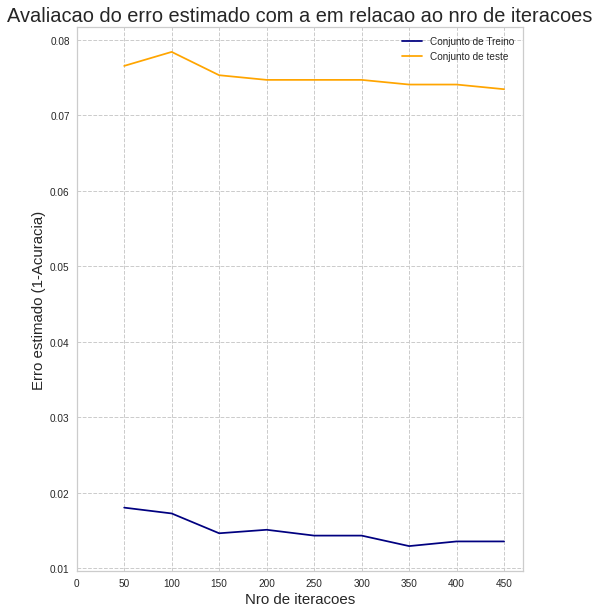

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(CAT_grid.cv_results_['param_clf__iterations'],1-CAT_grid.cv_results_['mean_train_score'],
         color='navy', label="Conjunto de Treino")
plt.plot(CAT_grid.cv_results_['param_clf__iterations'],1-CAT_grid.cv_results_['mean_test_score'],
         color='orange',label="Conjunto de teste")
plt.xlabel('Nro de iteracoes', fontdict={'fontsize': 15})
plt.ylabel('Erro estimado (1-Acuracia)', fontdict={'fontsize': 15})
plt.title('Avaliacao do erro estimado com a em relacao ao nro de iteracoes', fontdict={'fontsize': 20})
plt.xticks(range(0,500,50),)
plt.legend(loc='best')
plt.grid(linestyle="--")
plt.show()

Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
CAT_grid_predictions = CAT_grid.predict(X_test)#Predição da classe (y) dos dados de teste com o melhor modelo selecionado
 
print(classification_report(y_test, CAT_grid_predictions))#Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.96      0.87      0.91       298
       viral       0.91      0.97      0.94       397

    accuracy                           0.93       695
   macro avg       0.93      0.92      0.92       695
weighted avg       0.93      0.93      0.93       695



#3.5.5- *Gradient Boosting with XGBoost*

Importando biblioteca para aplicação do modelo:

In [ ]:
from xgboost import XGBClassifier

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
param_grid = {'clf__n_estimators' : np.arange(start=50, stop=500, step=50)}

XGB_model = Pipeline( steps=[
        ("clf", XGBClassifier())
    ]
)

XGB_grid = GridSearchCV(
    estimator=XGB_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)


Treinando o modelo

In [ ]:
XGB_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', XGBClassifier())]),
             param_grid={'clf__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
grid_table = pd.DataFrame(XGB_grid.cv_results_)
grid_table.head()

Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of {} with {} of accuracy.".format(XGB_grid.best_params_,XGB_grid.best_score_))

The best value of {'clf__n_estimators': 450} with 0.9253086419753087 of accuracy.


Plotando curva com os valores de erros estimado (1- media da acuracia) no conjunto de treino e de teste da validação cruzada.

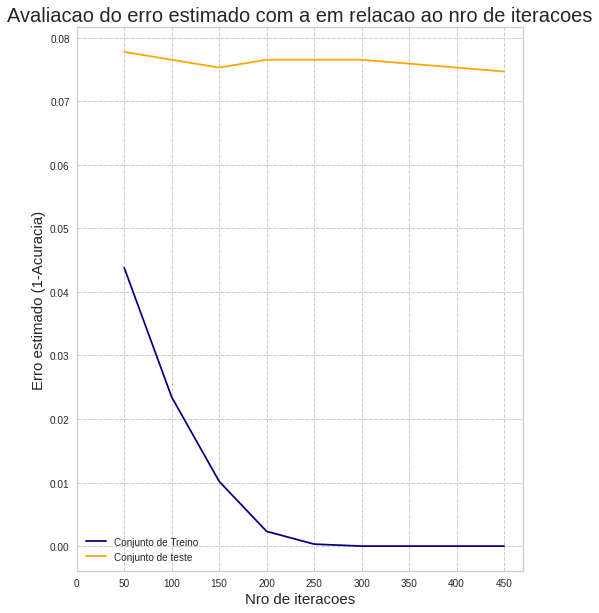

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(XGB_grid.cv_results_['param_clf__n_estimators'],1-XGB_grid.cv_results_['mean_train_score'],
         color='navy', label="Conjunto de Treino")
plt.plot(XGB_grid.cv_results_['param_clf__n_estimators'],1-XGB_grid.cv_results_['mean_test_score'],
         color='orange',label="Conjunto de teste")
plt.xlabel('Nro de iteracoes', fontdict={'fontsize': 15})
plt.ylabel('Erro estimado (1-Acuracia)', fontdict={'fontsize': 15})
plt.title('Avaliacao do erro estimado com a em relacao ao nro de iteracoes', fontdict={'fontsize': 20})
plt.xticks(range(0,500,50),)
plt.legend(loc='best')
plt.grid(linestyle="--")
plt.show()

Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
XGB_grid_predictions = XGB_grid.predict(X_test)#Predição da classe (y) dos dados de teste com o melhor modelo selecionado
 
print(classification_report(y_test, XGB_grid_predictions))#Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.95      0.88      0.91       298
       viral       0.92      0.96      0.94       397

    accuracy                           0.93       695
   macro avg       0.93      0.92      0.93       695
weighted avg       0.93      0.93      0.93       695



#3.5.6- *Gradient Boosting with LightGBM*

Importando biblioteca para aplicação do modelo:

In [ ]:
from lightgbm import LGBMClassifier

Estabelicmento dos hiperparâmetros a serem variados, validação cruzada com k-fold e computação da acurácia com *GridSearchCV()*:

In [ ]:
param_grid = {'clf__n_estimators' : np.arange(start=50, stop=500, step=25)}

LGB_model = Pipeline( steps=[
        ("clf", LGBMClassifier())
    ]
)

LGB_grid = GridSearchCV(
    estimator=LGB_model, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',return_train_score=True)


Treinando o modelo

In [ ]:
LGB_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', LGBMClassifier())]),
             param_grid={'clf__n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350,
       375, 400, 425, 450, 475])},
             return_train_score=True, scoring='accuracy')

Inspecionando a tabela com a performance dos classificadores em relação aos hiperparametros variados:

In [ ]:
grid_table = pd.DataFrame(LGB_grid.cv_results_)
grid_table.head()

Mostrando os melhores valores para os hiperparâmetros ajustados e a acúrácia resultante do modelo:

In [ ]:
print("The best value of {} with {} of accuracy.".format(LGB_grid.best_params_,LGB_grid.best_score_))

The best value of {'clf__n_estimators': 175} with 0.9265432098765432 of accuracy.


Plotando curva com os valores de erros estimado (1- media da acuracia) no conjunto de treino e de teste da validação cruzada.

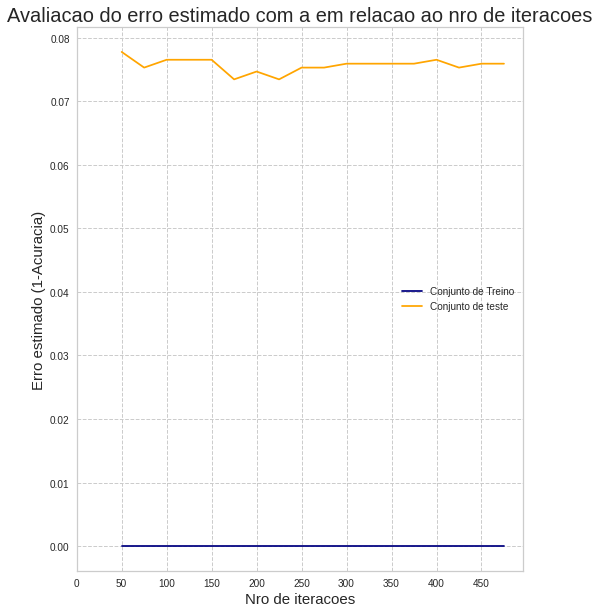

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(LGB_grid.cv_results_['param_clf__n_estimators'],1-LGB_grid.cv_results_['mean_train_score'],
         color='navy', label="Conjunto de Treino")
plt.plot(LGB_grid.cv_results_['param_clf__n_estimators'],1-LGB_grid.cv_results_['mean_test_score'],
         color='orange',label="Conjunto de teste")
plt.xlabel('Nro de iteracoes', fontdict={'fontsize': 15})
plt.ylabel('Erro estimado (1-Acuracia)', fontdict={'fontsize': 15})
plt.title('Avaliacao do erro estimado com a em relacao ao nro de iteracoes', fontdict={'fontsize': 20})
plt.xticks(range(0,500,50),)
plt.legend(loc='best')
plt.grid(linestyle="--")
plt.show()

Avaliando a performance do modelo com os melhores hiperparâmetros nos dados de teste (ainda não "vistos" pelo modelo):

In [ ]:
LGB_grid_predictions = LGB_grid.predict(X_test)#Predição da classe (y) dos dados de teste com o melhor modelo selecionado
 
print(classification_report(y_test, LGB_grid_predictions))#Comparando a classe das istâncias do dado de teste com as predições do modelo e imprimindo resumo com métricas da performance 

              precision    recall  f1-score   support

         eve       0.95      0.88      0.91       298
       viral       0.91      0.97      0.94       397

    accuracy                           0.93       695
   macro avg       0.93      0.92      0.93       695
weighted avg       0.93      0.93      0.93       695



# **4- Comparação dos métodos de classificação supervisionados**

# 4.1 Curvas ROC e DET

In [ ]:
classifiers = {
    'Naive Bayes' : NB_grid,
    'Decision Tree' : DT_grid,
    'SVM' : SVM_grid,
    'k-NN' : kNN_grid,
    'Rand. Forest' : RF_grid ,
    'G.T. Boost.': GTB_grid,
    'AdaBoost' :  AB_grid,
    'CATBoost' : CAT_grid,
     'XGBoost' : XGB_grid,
      'LightGBM': LGB_grid}

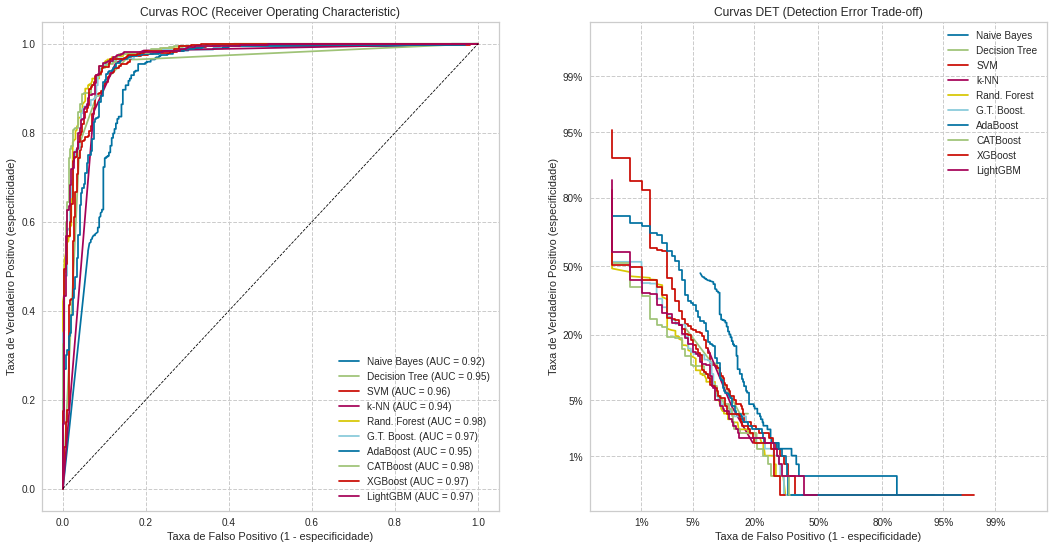

In [ ]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(18, 9))

for name, clf in classifiers.items():
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)


ax_roc.set_title("Curvas ROC (Receiver Operating Characteristic)")
ax_roc.set_ylabel("Taxa de Verdadeiro Positivo (especificidade)")
ax_roc.set_xlabel("Taxa de Falso Positivo (1 - especificidade)")

ax_det.set_title("Curvas DET (Detection Error Trade-off)")
ax_det.set_ylabel("Taxa de Verdadeiro Positivo (especificidade)")
ax_det.set_xlabel("Taxa de Falso Positivo (1 - especificidade)")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

ax_roc.plot([0,1],[0,1], linestyle='--', color="black",linewidth=0.8)
plt.legend()
plt.show()

# 4.2 Precision e Recall

Importando biblioteca para plotar curvas Precision/recall

In [ ]:
from sklearn.metrics import precision_recall_curve


In [ ]:
y_test_binario = y_test.replace(['viral','eve'],[0,1]) # alteracao do label para plotar a curva

Estimando as probabilidades

In [ ]:
NB_pred_prob = NB_grid.predict_proba(X_test)[:, 1]
NB_precision, NB_recall, thresholds = precision_recall_curve(y_test_binario,NB_pred_prob)

DT_pred_prob = DT_grid.predict_proba(X_test)[:, 1]
DT_precision, DT_recall, thresholds = precision_recall_curve(y_test_binario,DT_pred_prob)

kNN_pred_prob = kNN_grid.predict_proba(X_test)[:, 1]
kNN_precision, kNN_recall, thresholds = precision_recall_curve(y_test_binario,kNN_pred_prob)

RF_pred_prob = RF_grid.predict_proba(X_test)[:, 1]
RF_precision, RF_recall, thresholds = precision_recall_curve(y_test_binario,RF_pred_prob)

GTB_pred_prob = GTB_grid.predict_proba(X_test)[:, 1]
GTB_precision, GTB_recall, thresholds = precision_recall_curve(y_test_binario,GTB_pred_prob)

AB_pred_prob = AB_grid.predict_proba(X_test)[:, 1]
AB_precision, AB_recall, thresholds = precision_recall_curve(y_test_binario,AB_pred_prob)   

CAT_pred_prob = CAT_grid.predict_proba(X_test)[:, 1]
CAT_precision, CAT_recall, thresholds = precision_recall_curve(y_test_binario,CAT_pred_prob)   

XGB_pred_prob = XGB_grid.predict_proba(X_test)[:, 1]
XGB_precision, XGB_recall, thresholds = precision_recall_curve(y_test_binario,XGB_pred_prob) 

LGB_pred_prob = LGB_grid.predict_proba(X_test)[:, 1]
LGB_precision, LGB_recall, thresholds = precision_recall_curve(y_test_binario,LGB_pred_prob) 


Plotando curvas Precision/Recall

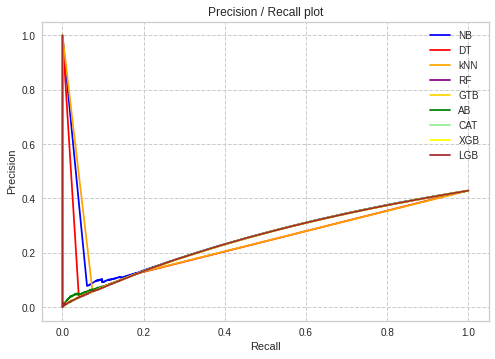

In [ ]:
plt.plot(NB_recall, NB_precision, label='NB',color="blue")
plt.plot(DT_recall, DT_precision,label='DT',color="red") 
plt.plot(kNN_recall, kNN_precision, label='kNN',color="orange" )
plt.plot(RF_recall, RF_precision, label='RF',color="purple" )
plt.plot(GTB_recall, GTB_precision, label='GTB',color="gold" )
plt.plot(AB_recall, AB_precision, label='AB',color="green" )
plt.plot(CAT_recall, CAT_precision, label='CAT',color="lightgreen" )
plt.plot(XGB_recall, XGB_precision, label='XGB',color="yellow" )
plt.plot(LGB_recall, LGB_precision, label='LGB',color="brown" )


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision / Recall plot')
plt.grid(linestyle="--")
# Legenda
plt.legend()


Resumindo avaliações de performance dos modelos ensemble tunados:

In [ ]:
print("#########------------------ Random Forest ----------------------############")
print(classification_report(y_test, RF_grid_predictions))
print("#########------------------ AdaBoost ----------------------############")
print(classification_report(y_test, AB_grid_predictions))
print("#########------------------ GTBoost ----------------------############")
print(classification_report(y_test, GTB_grid_predictions))
print("#########------------------ CATBoost  ----------------------############")
print(classification_report(y_test, CAT_grid_predictions))
print("#########------------------  XGBoost ----------------------############")
print(classification_report(y_test, XGB_grid_predictions))
print("#########------------------  LightGBM ----------------------############")
print(classification_report(y_test, LGB_grid_predictions))

#########------------------ Random Forest ----------------------############
              precision    recall  f1-score   support

         eve       0.96      0.87      0.91       298
       viral       0.91      0.97      0.94       397

    accuracy                           0.93       695
   macro avg       0.93      0.92      0.92       695
weighted avg       0.93      0.93      0.93       695

#########------------------ AdaBoost ----------------------############
              precision    recall  f1-score   support

         eve       0.94      0.87      0.90       298
       viral       0.91      0.96      0.93       397

    accuracy                           0.92       695
   macro avg       0.92      0.91      0.92       695
weighted avg       0.92      0.92      0.92       695

#########------------------ GTBoost ----------------------############
              precision    recall  f1-score   support

         eve       0.94      0.89      0.91       298
       viral     

O "recall" da classe "eve" está sempre mais baixo em todas avaliações. Provavel consequência da classe possuir menos exemplos.

**Conclusões**: As analises exploratórias dos dados e a aplicação de modelos de aprendizado não-supervisionado evidenciam que a enegenharia de atributos e pre-processamento dos dados foram etapas de sucesso nesse projeto. Os modelos supervisionados estão com métricas de performance muito altas, um exemplos são Random Forest e CATBoost com AUC = 0.98. Eu avalio tais valores com desconfiança, principalmente pelo baixo volume de dados e alta possibildiade de overfitting. Minha meta para concluir esse ramo do meu projeto de doutorado é dobrar o volume de dados e voltar a fazer esses experimentos. No momento, nossa hipótese de que os atributos advindos da interação virus/hospedeiro seriam bons descritores dos dados para se aplicar aprendizado de máquina nesse problema de classificação parece estar correta.